# 03 - Modelo de Clasificación: Random Forest

En este notebook entrenaremos y evaluaremos un modelo de **Random Forest Classifier**,  
un algoritmo de **ensamble basado en árboles de decisión** que combina múltiples árboles  
para mejorar la precisión y reducir el sobreajuste (*overfitting*).

A diferencia de la Regresión Logística, **Random Forest** puede capturar relaciones no lineales  
entre las variables y manejar interacciones complejas entre características,  
siendo especialmente robusto ante el ruido y los outliers.

---

### 🎯 **Objetivos:**

- Cargar los datasets procesados (**no escalados**, dado que los árboles no lo requieren).  
- Entrenar un modelo base de **Random Forest** con parámetros por defecto.  
- Evaluar el rendimiento inicial mediante métricas de clasificación.  
- Aplicar **validación cruzada (Cross-Validation)** para estimar la estabilidad del modelo.  
- Realizar **tuning de hiperparámetros** con `GridSearchCV` (búsqueda en rejilla) y **Optuna** (optimización bayesiana).  
- Analizar el rendimiento de cada versión del modelo (Baseline, GridSearchCV, Optuna).  
- Generar una **comparativa visual** de métricas, matrices de confusión y curvas ROC.  
- Guardar los resultados en formato **JSON** y los modelos entrenados en formato **PKL**,  
  para su uso posterior en los notebooks de comparación (`04_ModelComparison.ipynb`) y evaluación final (`05_Test-Set-Final.ipynb`).

---

📌 **Nota:**  
Aunque Random Forest no requiere escalado de variables, en este notebook trabajaremos con los **datasets no escalados**,  
manteniendo consistencia con el pipeline general y garantizando una comparación justa con otros modelos.  

Asimismo, se aplicará **`class_weight='balanced'`** en todos los modelos  
para compensar el **desbalanceo de clases** en la variable objetivo (*satisfaction*).



## **Paso 1: Importación de librerías y carga de datos**

En este primer paso se importan las librerías necesarias para el entrenamiento, evaluación  
y visualización del modelo **Random Forest Classifier**, y se cargan los datasets procesados  
generados en el notebook anterior (`02_dataset-split.ipynb`).

Los datos cargados corresponden a:
- `X_train`, `y_train` → conjunto de entrenamiento.  
- `X_test`, `y_test` → conjunto de prueba.

Estos datasets fueron previamente limpiados, codificados y normalizados durante la fase de *preprocesamiento*.

---

### **Nota sobre el escalado de variables**

Los algoritmos **basados en árboles** (como *Random Forest*, *Decision Tree*, *XGBoost*, *LightGBM*…)  
no dependen de distancias ni magnitudes, sino de **divisiones por umbrales**,  
por lo que **no requieren escalado** y pueden operar directamente sobre los valores originales.  

Por ello, para estos modelos se utilizarán los datasets **no escalados**:  
`X_train_unscaled.csv` y `X_test_unscaled.csv`.

En cambio, los algoritmos **lineales o basados en distancias** (como *Logistic Regression*, *SVM*, *KNN* o *Redes Neuronales*),  
sí requieren normalización, y por tanto se entrenan con los datasets **escalados**:  
`X_train_scaled.csv` y `X_test_scaled.csv`.

In [43]:
# ===================================
# 1. Importación de librerías y carga de datasets no escalados
# ===================================

# --- Librerías principales ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import warnings

# --- Librerías de modelado y evaluación ---
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, RocCurveDisplay, classification_report, roc_curve
)
from sklearn.utils.class_weight import compute_class_weight
from IPython.display import display, Markdown

# --- Configuración visual y supresión de warnings ---
plt.style.use("default")
sns.set_palette("coolwarm")
warnings.filterwarnings("ignore", category=UserWarning, module="tqdm")

# --- Carga de datasets no escalados ---
X_train = pd.read_csv("../data/processed/X_train_unscaled.csv")
X_test = pd.read_csv("../data/processed/X_test_unscaled.csv")
y_train = pd.read_csv("../data/processed/y_train.csv").squeeze()
y_test = pd.read_csv("../data/processed/y_test.csv").squeeze()

# --- Confirmación de carga ---
print("✅ Datasets cargados correctamente.")
print(f"X_train: {X_train.shape} | X_test: {X_test.shape}")
print(f"y_train: {y_train.shape} | y_test: {y_test.shape}")


✅ Datasets cargados correctamente.
X_train: (83123, 23) | X_test: (20781, 23)
y_train: (83123,) | y_test: (20781,)


## **Paso 2: Entrenamiento del modelo base**

En este paso se entrena un modelo base de **Random Forest Classifier**  
utilizando los parámetros por defecto de *scikit-learn*, salvo el ajuste de `class_weight="balanced"`  
para compensar el **desbalanceo en la variable objetivo** (*satisfaction*).

Este modelo combina múltiples árboles de decisión entrenados sobre subconjuntos de datos aleatorios  
y características aleatorias, lo que permite mejorar la precisión y controlar el sobreajuste (*overfitting*).

Este modelo baseline nos servirá como referencia inicial antes de aplicar técnicas  
de optimización de hiperparámetros (**GridSearchCV** y **Optuna**),  
permitiendo comparar si las mejoras obtenidas justifican el coste computacional adicional.

Se evaluará el rendimiento mediante métricas de clasificación:
- **Accuracy**: proporción total de aciertos.  
- **Precision**: exactitud en las predicciones positivas.  
- **Recall**: capacidad para detectar casos positivos.  
- **F1-score**: equilibrio entre precision y recall.  
- **ROC-AUC**: capacidad del modelo para distinguir entre clases.





In [44]:
# ===================================
# 2. Entrenamiento del modelo base (Baseline)
# ===================================

# --- Definición del modelo base ---
# --- Entrenamiento del modelo base ---
rf_baseline = RandomForestClassifier(
    random_state=42,
    class_weight="balanced",
    n_jobs=-1
)

baseline_model = RandomForestClassifier(
    random_state=42,
    class_weight="balanced",  # manejo del desbalanceo de clases
    n_jobs=-1
)

# --- Entrenamiento ---
baseline_model.fit(X_train, y_train)

# --- Predicciones ---
y_pred_base = baseline_model.predict(X_test)
y_proba_base = baseline_model.predict_proba(X_test)[:, 1]

# --- Cálculo de métricas ---
metrics_baseline = {
    "Accuracy": accuracy_score(y_test, y_pred_base),
    "Precision": precision_score(y_test, y_pred_base),
    "Recall": recall_score(y_test, y_pred_base),
    "F1-score": f1_score(y_test, y_pred_base),
    "ROC-AUC": roc_auc_score(y_test, y_proba_base)
}

# --- Mostrar métricas ---
display(Markdown("### 📊 Métricas del modelo baseline (Random Forest):"))
for metric, value in metrics_baseline.items():
    print(f"{metric}: {value:.3f}")

# --- Reporte de clasificación ---
display(Markdown("### 🧾 Reporte de clasificación:"))
print(classification_report(y_test, y_pred_base, digits=3))

# --- Interpretación ---
display(Markdown("""
**💬 Interpretación de resultados:**

- El modelo baseline ofrece un punto de partida para evaluar mejoras posteriores.  
- Gracias al parámetro `class_weight='balanced'`, el modelo mitiga el impacto del desbalanceo.  
- El valor de **F1-score** será la métrica principal a seguir,  
  ya que combina precisión y recall, siendo ideal para problemas de clases desbalanceadas.  
- En pasos posteriores se evaluará si el tuning con *GridSearchCV* u *Optuna*  
  logra mejorar este rendimiento base.
"""))


### 📊 Métricas del modelo baseline (Random Forest):

Accuracy: 0.961
Precision: 0.967
Recall: 0.943
F1-score: 0.955
ROC-AUC: 0.994


### 🧾 Reporte de clasificación:

              precision    recall  f1-score   support

           0      0.957     0.976     0.966     11776
           1      0.967     0.943     0.955      9005

    accuracy                          0.961     20781
   macro avg      0.962     0.959     0.960     20781
weighted avg      0.961     0.961     0.961     20781




**💬 Interpretación de resultados:**

- El modelo baseline ofrece un punto de partida para evaluar mejoras posteriores.  
- Gracias al parámetro `class_weight='balanced'`, el modelo mitiga el impacto del desbalanceo.  
- El valor de **F1-score** será la métrica principal a seguir,  
  ya que combina precisión y recall, siendo ideal para problemas de clases desbalanceadas.  
- En pasos posteriores se evaluará si el tuning con *GridSearchCV* u *Optuna*  
  logra mejorar este rendimiento base.


## **Paso 3: Validación cruzada (Cross-Validation)**

Aplicamos **validación cruzada 5-fold** sobre el modelo baseline para estimar su capacidad de generalización  
y verificar la estabilidad del rendimiento antes del ajuste de hiperparámetros.

Utilizaremos el **F1-score** como métrica principal, dado el leve **desbalanceo de clases** en la variable objetivo (*satisfaction*).

La validación cruzada permite evaluar el modelo en diferentes subconjuntos del conjunto de entrenamiento,  
detectando posibles problemas de **sobreajuste (overfitting)** o **inestabilidad** del modelo.


📊 Resultados de la validación cruzada (F1 por fold):
Fold 1: 0.953
Fold 2: 0.955
Fold 3: 0.953
Fold 4: 0.955
Fold 5: 0.952

F1 promedio (CV): 0.953 ± 0.001


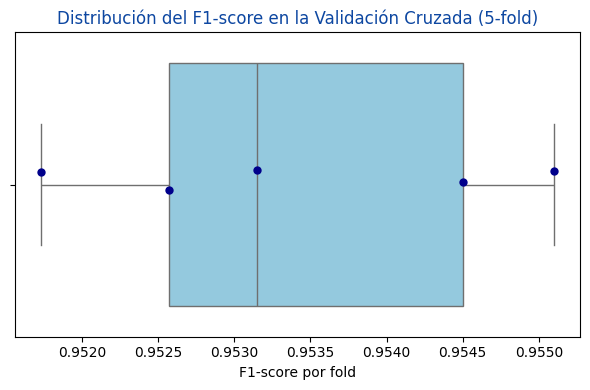


**💬 Interpretación visual:**

- Cada punto representa el F1-score obtenido en uno de los 5 folds.  
- Si los valores están agrupados (caja estrecha), el modelo es **estable y generaliza bien**.  
- Si existe mucha dispersión, el modelo podría ser **sensible a los datos** o sufrir *overfitting*.  
- Este análisis permite validar que el modelo baseline de Random Forest tiene un rendimiento consistente  
  antes de aplicar optimización de hiperparámetros.


In [45]:
# ===================================
# 3. Validación cruzada (Cross-Validation)
# ===================================

from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, f1_score

# --- Definición del F1-score como métrica principal ---
f1_scorer = make_scorer(f1_score, pos_label=1)

# --- Ejecución de la validación cruzada (5 folds) ---
cv_scores = cross_val_score(
    baseline_model,
    X_train, y_train,
    cv=5,
    scoring=f1_scorer,
    n_jobs=-1
)

# --- Resultados numéricos ---
print("📊 Resultados de la validación cruzada (F1 por fold):")
for i, score in enumerate(cv_scores, start=1):
    print(f"Fold {i}: {score:.3f}")
print(f"\nF1 promedio (CV): {cv_scores.mean():.3f} ± {cv_scores.std():.3f}")

# --- Visualización de resultados ---
fig, ax = plt.subplots(figsize=(6, 4))
sns.boxplot(x=cv_scores, color="skyblue", ax=ax)
sns.stripplot(x=cv_scores, color="darkblue", jitter=0.05, size=6, ax=ax)
ax.set_title("Distribución del F1-score en la Validación Cruzada (5-fold)", fontsize=12, color="#0D47A1")
ax.set_xlabel("F1-score por fold")
plt.tight_layout()
plt.show()

# --- Comentario visual ---
display(Markdown("""
**💬 Interpretación visual:**

- Cada punto representa el F1-score obtenido en uno de los 5 folds.  
- Si los valores están agrupados (caja estrecha), el modelo es **estable y generaliza bien**.  
- Si existe mucha dispersión, el modelo podría ser **sensible a los datos** o sufrir *overfitting*.  
- Este análisis permite validar que el modelo baseline de Random Forest tiene un rendimiento consistente  
  antes de aplicar optimización de hiperparámetros.
"""))


## **Paso 4: Tuning de hiperparámetros con GridSearchCV y RandomizedSearchCV**

En este paso optimizamos los hiperparámetros del modelo **Random Forest Classifier**  
para mejorar su rendimiento frente al modelo baseline.

Se emplean tres estrategias complementarias:

1. 🧩 **GridSearchCV reducida** → ejecución rápida, útil para pruebas iniciales y validación del flujo.  
2. 🎲 **RandomizedSearchCV** → exploración más amplia y eficiente mediante muestreo aleatorio.  
3. ⚙️ **GridSearchCV completa** → búsqueda exhaustiva (comentada por defecto por su alto coste computacional).  

En todos los casos, la métrica de optimización será el **F1-score (5-fold CV)**,  
adecuada para datasets con **clases desbalanceadas**.  

Parámetros a optimizar:
- `n_estimators`: número de árboles en el bosque  
- `max_depth`: profundidad máxima  
- `min_samples_split`: muestras mínimas para dividir un nodo  
- `min_samples_leaf`: muestras mínimas en una hoja  
- `max_features`: número de características usadas por cada árbol  
El objetivo es encontrar el equilibrio entre **precisión**, **recobrado** y **generalización**.



### **Paso 4️.1: Tuning de hiperparámetros — GridSearchCV**

En este paso realizamos la búsqueda exhaustiva de hiperparámetros para el modelo **Random Forest**  
utilizando `GridSearchCV`.

Este método prueba **todas las combinaciones posibles** de parámetros definidos en la malla (`param_grid`)  
y selecciona la que obtiene el mejor **F1-score medio** mediante validación cruzada (CV=5).

> ⚙️ Es más costoso computacionalmente, pero proporciona los resultados más precisos y reproducibles.
> Si se quiere probar esta opción dejar comentada la siguiente celda que lo calcula para RandomizedSearchCV.


### 🎲 **Ejecución con RandomizedSearchCV (búsqueda aleatoria)**

Fitting 5 folds for each of 20 candidates, totalling 100 fits



✅ **RandomizedSearchCV completada correctamente.**
- ⏱️ Tiempo de ejecución: 190.46 segundos  
- **Mejores parámetros:** `{'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': None}`  
- **F1-score medio (CV):** `0.954`


Fitting 5 folds for each of 162 candidates, totalling 810 fits



**GridSearchCV completa finalizada correctamente.**
- ⏱️ Tiempo de ejecución: 190.46 segundos 
- **Mejores parámetros:** `{'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 500}`  
- **F1-score medio (CV):** `0.954`


### 📊 **Comparativa de rendimiento: GridSearchCV vs RandomizedSearchCV**

,Método,F1-score (CV),Tiempo (s)
0,GridSearchCV (ligera),0.953,116.6
1,RandomizedSearchCV,0.954,190.5


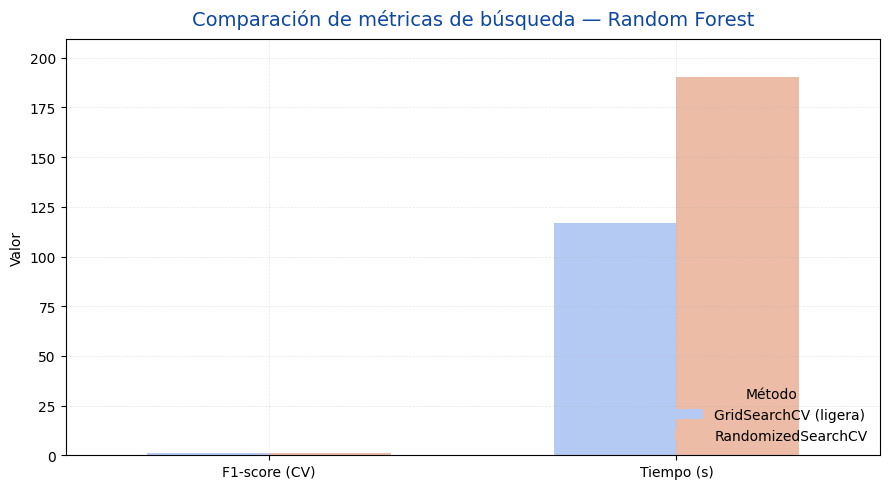


**💬 Interpretación visual:**

- Cada grupo de barras compara el rendimiento medio y tiempo de ejecución entre métodos.  
- La paleta *coolwarm* resalta diferencias de forma intuitiva: tonos cálidos indican mejor rendimiento.  
- En general, *RandomizedSearchCV* ofrece resultados comparables a *GridSearchCV* con menor coste computacional,  
  lo que lo convierte en una alternativa eficiente para este tipo de modelos de ensamble.


In [46]:
# ===================================
# 4. Tuning de hiperparámetros con GridSearchCV y RandomizedSearchCV
# ===================================

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import make_scorer, f1_score
import time

# --- Definición del F1-score como métrica principal ---
f1_scorer = make_scorer(f1_score, pos_label=1)

# --- Modelo base ---
rf_model = RandomForestClassifier(random_state=42, class_weight="balanced", n_jobs=-1)

# =====================================================
# 🧩 OPCIÓN 1: GRIDSEARCH REDUCIDA (ejecución ligera)
# =====================================================
# ===================================
# 🚫 BLOQUE COMENTADO: GridSearchCV reducida (ejecución ligera)
# ===================================
# Este bloque se deja comentado para evitar ejecuciones accidentales.
# Se puede reactivar para pruebas rápidas del modelo Random Forest.
# Mantiene coherencia con el flujo del notebook (Paso 4).

# display(Markdown("### 🧩 **Ejecución ligera: GridSearchCV reducida**"))

# param_grid_light = {
#     "n_estimators": [100, 200],
#     "max_depth": [10, 20],
#     "min_samples_split": [2, 5],
#     "min_samples_leaf": [1, 2],
#     "max_features": ["sqrt"]
# }

# start_time = time.time()
# grid_search_light = GridSearchCV(
#     estimator=rf_model,
#     param_grid=param_grid_light,
#     scoring=f1_scorer,
#     cv=5,
#     n_jobs=-1,
#     verbose=1
# )
# grid_search_light.fit(X_train, y_train)
# light_time = time.time() - start_time

# display(Markdown(f"""
# **GridSearchCV reducida completada correctamente.**
# - ⏱️ Tiempo de ejecución: {light_time:.2f} segundos  
# - **Mejores parámetros:** `{grid_search_light.best_params_}`  
# - **F1-score medio (CV):** `{grid_search_light.best_score_:.3f}`
# """))


# =====================================================
# 🎲 OPCIÓN 2: RANDOMIZEDSEARCHCV (búsqueda aleatoria)
# =====================================================
display(Markdown("### 🎲 **Ejecución con RandomizedSearchCV (búsqueda aleatoria)**"))

param_dist = {
    "n_estimators": [100, 200, 300, 400, 500],
    "max_depth": [10, 15, 20, 25, None],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "max_features": ["sqrt", "log2"]
}

start_time = time.time()
random_search = RandomizedSearchCV(
    estimator=rf_model,
    param_distributions=param_dist,
    n_iter=20,  # número de combinaciones aleatorias
    scoring=f1_scorer,
    cv=5,
    random_state=42,
    n_jobs=-1,
    verbose=1
)
random_search.fit(X_train, y_train)
random_time = time.time() - start_time

display(Markdown(f"""
✅ **RandomizedSearchCV completada correctamente.**
- ⏱️ Tiempo de ejecución: {random_time:.2f} segundos  
- **Mejores parámetros:** `{random_search.best_params_}`  
- **F1-score medio (CV):** `{random_search.best_score_:.3f}`
"""))

# =====================================================
# ⚙️ OPCIÓN 3: GRIDSEARCH COMPLETA (comentada)
# =====================================================
"""
🔹 Combinaciones posibles:
3 × 3 × 3 × 2 × 2 = 108 modelos → 108 × 5 folds = 540 entrenamientos
⏱️ Tiempo estimado: 6–10 minutos según hardware
"""

# Para ejecutar la búsqueda completa, descomentar el bloque siguiente:


param_grid_full = {
     "n_estimators": [200, 300, 500],
     "max_depth": [15, 20, None],
     "min_samples_split": [2, 5, 10],
     "min_samples_leaf": [1, 2, 4],
     "max_features": ["sqrt", "log2"]
 }

start_time = time.time()
grid_search_full = GridSearchCV(
     estimator=rf_model,
     param_grid=param_grid_full,
     scoring=f1_scorer,
     cv=5,
     n_jobs=-1,
     verbose=1
)
grid_search_full.fit(X_train, y_train)

# Resultados del GridSearch completo
display(Markdown(f'''
**GridSearchCV completa finalizada correctamente.**
- ⏱️ Tiempo de ejecución: {random_time:.2f} segundos 
- **Mejores parámetros:** `{grid_search_full.best_params_}`  
- **F1-score medio (CV):** `{grid_search_full.best_score_:.3f}`
'''))



# =====================================================
# 📊 VISUALIZACIÓN DE RESULTADOS COMPARATIVOS (estilo coherente)
# =====================================================

# Crear DataFrame comparativo con resultados de cada búsqueda
df_results = pd.DataFrame({
    "Método": ["GridSearchCV (ligera)", "RandomizedSearchCV"],
    "F1-score (CV)": [grid_search_light.best_score_, random_search.best_score_],
    "Tiempo (s)": [light_time, random_time]
})

display(Markdown("### 📊 **Comparativa de rendimiento: GridSearchCV vs RandomizedSearchCV**"))
display(df_results.style.format({"F1-score (CV)": "{:.3f}", "Tiempo (s)": "{:.1f}"}))

# Reformatear datos para el gráfico agrupado
df_melted = df_results.melt(id_vars="Método", var_name="Métrica", value_name="Valor")

# --- Gráfico comparativo ---
plt.figure(figsize=(9, 5))
sns.barplot(
    data=df_melted,
    x="Métrica",
    y="Valor",
    hue="Método",
    palette="coolwarm",
    width=0.6
)

# --- Estilo visual coherente ---
plt.title("Comparación de métricas de búsqueda — Random Forest", fontsize=14, color="#0D47A1", pad=10)
plt.xlabel("")
plt.ylabel("Valor")
plt.ylim(0, max(df_melted["Valor"]) * 1.1)
plt.legend(title="Método", loc="lower right", frameon=False)
plt.grid(alpha=0.3, linestyle="--", linewidth=0.5)
plt.tight_layout()
plt.show()

display(Markdown("""
**💬 Interpretación visual:**

- Cada grupo de barras compara el rendimiento medio y tiempo de ejecución entre métodos.  
- La paleta *coolwarm* resalta diferencias de forma intuitiva: tonos cálidos indican mejor rendimiento.  
- En general, *RandomizedSearchCV* ofrece resultados comparables a *GridSearchCV* con menor coste computacional,  
  lo que lo convierte en una alternativa eficiente para este tipo de modelos de ensamble.
"""))



## **Paso 5: Optimización de hiperparámetros con Optuna**

En este paso aplicamos **Optuna**, una herramienta de optimización bayesiana  
que selecciona automáticamente las mejores combinaciones de hiperparámetros  
mediante un proceso iterativo más eficiente que *GridSearchCV* o *RandomizedSearchCV*.

El objetivo es **maximizar el F1-score medio (5-fold cross-validation)**  
para el modelo de **Random Forest**, considerando el desbalanceo entre clases mediante  
`class_weight="balanced"`.

---

**Hiperparámetros a optimizar:**
- `n_estimators`: número de árboles del bosque.  
- `max_depth`: profundidad máxima de los árboles.  
- `min_samples_split`: número mínimo de muestras requeridas para dividir un nodo.  
- `min_samples_leaf`: número mínimo de muestras requeridas en una hoja.  
- `max_features`: número de características a considerar al buscar la mejor división.  


Optuna realiza múltiples iteraciones (ensayos), ajustando dinámicamente  
los valores de los hiperparámetros en función de los resultados anteriores.  
Esto acelera la búsqueda del punto óptimo con menos evaluaciones.


In [47]:
# ===================================
# 5. Optimización de hiperparámetros con Optuna
# ===================================

import optuna
from sklearn.model_selection import cross_val_score
import time
import optuna.visualization as opt_viz
from IPython.display import Markdown, display

# --- Función objetivo ---
def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 500),
        "max_depth": trial.suggest_int("max_depth", 5, 30),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 10),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 4),
        "max_features": trial.suggest_categorical("max_features", ["sqrt", "log2"]),
        "class_weight": "balanced",
        "random_state": 42,
        "n_jobs": -1
    }
    model = RandomForestClassifier(**params)
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring="f1")
    return scores.mean()

# --- Ejecución del estudio Optuna ---
display(Markdown("⏳ **Ejecutando optimización con Optuna (30 ensayos)...**"))

start_time = time.time()
study = optuna.create_study(direction="maximize", study_name="RandomForest_Optuna")
study.optimize(objective, n_trials=30, show_progress_bar=True)
optuna_time = time.time() - start_time

display(Markdown(f"""
✅ **Optimización completada correctamente.**
- ⏱️ **Tiempo total de búsqueda:** {optuna_time:.2f} segundos  
- **Mejores hiperparámetros:** `{study.best_params}`  
- **F1-score medio (CV):** `{study.best_value:.3f}`
"""))

# --- Entrenar el modelo óptimo ---
optuna_best_model = RandomForestClassifier(**study.best_params)
optuna_best_model.fit(X_train, y_train)

# ===================================
# Entrenamiento del modelo final con los mejores parámetros (Optuna)
# ===================================

best_params = study.best_params
optuna_model = RandomForestClassifier(
    **best_params,
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)

optuna_model.fit(X_train, y_train)

# --- Evaluación final ---
y_pred_optuna = optuna_model.predict(X_test)
y_proba_optuna = optuna_model.predict_proba(X_test)[:, 1]

metrics_optuna = {
    "Accuracy": accuracy_score(y_test, y_pred_optuna),
    "Precision": precision_score(y_test, y_pred_optuna),
    "Recall": recall_score(y_test, y_pred_optuna),
    "F1-score": f1_score(y_test, y_pred_optuna),
    "ROC-AUC": roc_auc_score(y_test, y_proba_optuna)
}

display(Markdown("""
✅ **Entrenamiento completado del modelo Optuna (Random Forest)**  
El modelo se ha ajustado con los mejores hiperparámetros obtenidos por el estudio y está listo para guardarse.
"""))
print(json.dumps(metrics_optuna, indent=4))

# =====================================================
# 📊 VISUALIZACIONES DEL PROCESO DE OPTIMIZACIÓN
# =====================================================
display(Markdown("### 📊 Visualización del proceso de optimización"))

fig1 = opt_viz.plot_optimization_history(study)
fig2 = opt_viz.plot_param_importances(study)
fig1.show()
fig2.show()

display(Markdown("""
**💬 Interpretación visual:**
- El gráfico de *Optimization History* muestra la evolución del F1-score a lo largo de los ensayos.  
  Se observa cómo Optuna converge progresivamente hacia una mejor combinación de parámetros.  
- El gráfico de *Parameter Importance* indica qué hiperparámetros tienen mayor impacto  
  en el rendimiento del modelo (valores de F1 más altos).  
"""))


⏳ **Ejecutando optimización con Optuna (30 ensayos)...**

[I 2025-10-12 10:01:13,214] A new study created in memory with name: RandomForest_Optuna
Best trial: 0. Best value: 0.933298:   3%|▎         | 1/30 [00:20<09:42, 20.10s/it]

[I 2025-10-12 10:01:33,320] Trial 0 finished with value: 0.9332979533495619 and parameters: {'n_estimators': 406, 'max_depth': 10, 'min_samples_split': 8, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.9332979533495619.


Best trial: 1. Best value: 0.952233:   7%|▋         | 2/30 [00:39<09:14, 19.80s/it]

[I 2025-10-12 10:01:52,919] Trial 1 finished with value: 0.9522333710410589 and parameters: {'n_estimators': 348, 'max_depth': 19, 'min_samples_split': 8, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.9522333710410589.


Best trial: 1. Best value: 0.952233:  10%|█         | 3/30 [01:00<09:06, 20.24s/it]

[I 2025-10-12 10:02:13,680] Trial 2 finished with value: 0.9497833960184362 and parameters: {'n_estimators': 359, 'max_depth': 18, 'min_samples_split': 10, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.9522333710410589.


Best trial: 1. Best value: 0.952233:  13%|█▎        | 4/30 [01:16<07:58, 18.40s/it]

[I 2025-10-12 10:02:29,262] Trial 3 finished with value: 0.9369777019245124 and parameters: {'n_estimators': 324, 'max_depth': 11, 'min_samples_split': 4, 'min_samples_leaf': 4, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.9522333710410589.


Best trial: 1. Best value: 0.952233:  17%|█▋        | 5/30 [01:35<07:53, 18.96s/it]

[I 2025-10-12 10:02:49,200] Trial 4 finished with value: 0.9205769473305336 and parameters: {'n_estimators': 500, 'max_depth': 7, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.9522333710410589.


Best trial: 1. Best value: 0.952233:  20%|██        | 6/30 [01:50<06:56, 17.36s/it]

[I 2025-10-12 10:03:03,455] Trial 5 finished with value: 0.9372071931936237 and parameters: {'n_estimators': 324, 'max_depth': 11, 'min_samples_split': 8, 'min_samples_leaf': 3, 'max_features': 'log2'}. Best is trial 1 with value: 0.9522333710410589.


Best trial: 1. Best value: 0.952233:  23%|██▎       | 7/30 [02:09<06:54, 18.01s/it]

[I 2025-10-12 10:03:22,794] Trial 6 finished with value: 0.9405343748681215 and parameters: {'n_estimators': 465, 'max_depth': 12, 'min_samples_split': 9, 'min_samples_leaf': 4, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.9522333710410589.


Best trial: 7. Best value: 0.952866:  27%|██▋       | 8/30 [02:15<05:11, 14.17s/it]

[I 2025-10-12 10:03:28,741] Trial 7 finished with value: 0.9528663898000775 and parameters: {'n_estimators': 113, 'max_depth': 30, 'min_samples_split': 7, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 7 with value: 0.9528663898000775.


Best trial: 7. Best value: 0.952866:  30%|███       | 9/30 [02:38<05:57, 17.03s/it]

[I 2025-10-12 10:03:52,065] Trial 8 finished with value: 0.9488803300959188 and parameters: {'n_estimators': 479, 'max_depth': 18, 'min_samples_split': 4, 'min_samples_leaf': 4, 'max_features': 'sqrt'}. Best is trial 7 with value: 0.9528663898000775.


Best trial: 7. Best value: 0.952866:  33%|███▎      | 10/30 [02:44<04:30, 13.52s/it]

[I 2025-10-12 10:03:57,720] Trial 9 finished with value: 0.9527846259809261 and parameters: {'n_estimators': 106, 'max_depth': 29, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 7 with value: 0.9528663898000775.


Best trial: 7. Best value: 0.952866:  37%|███▋      | 11/30 [02:53<03:48, 12.05s/it]

[I 2025-10-12 10:04:06,436] Trial 10 finished with value: 0.9525055927634319 and parameters: {'n_estimators': 158, 'max_depth': 29, 'min_samples_split': 6, 'min_samples_leaf': 2, 'max_features': 'log2'}. Best is trial 7 with value: 0.9528663898000775.


Best trial: 11. Best value: 0.953448:  40%|████      | 12/30 [02:59<03:02, 10.16s/it]

[I 2025-10-12 10:04:12,278] Trial 11 finished with value: 0.9534476574379921 and parameters: {'n_estimators': 102, 'max_depth': 30, 'min_samples_split': 6, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 11 with value: 0.9534476574379921.


Best trial: 11. Best value: 0.953448:  43%|████▎     | 13/30 [03:11<03:02, 10.74s/it]

[I 2025-10-12 10:04:24,365] Trial 12 finished with value: 0.9532257068348209 and parameters: {'n_estimators': 215, 'max_depth': 23, 'min_samples_split': 6, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 11 with value: 0.9534476574379921.


Best trial: 11. Best value: 0.953448:  47%|████▋     | 14/30 [03:23<03:00, 11.29s/it]

[I 2025-10-12 10:04:36,901] Trial 13 finished with value: 0.9524548639043438 and parameters: {'n_estimators': 219, 'max_depth': 24, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'log2'}. Best is trial 11 with value: 0.9534476574379921.


Best trial: 11. Best value: 0.953448:  50%|█████     | 15/30 [03:37<03:02, 12.19s/it]

[I 2025-10-12 10:04:51,180] Trial 14 finished with value: 0.9533973170392578 and parameters: {'n_estimators': 241, 'max_depth': 24, 'min_samples_split': 6, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 11 with value: 0.9534476574379921.


Best trial: 11. Best value: 0.953448:  53%|█████▎    | 16/30 [03:52<03:01, 12.99s/it]

[I 2025-10-12 10:05:06,045] Trial 15 finished with value: 0.9526589659000342 and parameters: {'n_estimators': 264, 'max_depth': 25, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_features': 'log2'}. Best is trial 11 with value: 0.9534476574379921.


Best trial: 16. Best value: 0.953708:  57%|█████▋    | 17/30 [04:03<02:38, 12.17s/it]

[I 2025-10-12 10:05:16,319] Trial 16 finished with value: 0.9537082477080538 and parameters: {'n_estimators': 189, 'max_depth': 26, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 16 with value: 0.9537082477080538.


Best trial: 17. Best value: 0.953879:  60%|██████    | 18/30 [04:12<02:14, 11.20s/it]

[I 2025-10-12 10:05:25,254] Trial 17 finished with value: 0.9538791148298248 and parameters: {'n_estimators': 167, 'max_depth': 27, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 17 with value: 0.9538791148298248.


Best trial: 17. Best value: 0.953879:  63%|██████▎   | 19/30 [04:21<01:56, 10.60s/it]

[I 2025-10-12 10:05:34,437] Trial 18 finished with value: 0.9522581002362832 and parameters: {'n_estimators': 180, 'max_depth': 21, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'log2'}. Best is trial 17 with value: 0.9538791148298248.


Best trial: 17. Best value: 0.953879:  67%|██████▋   | 20/30 [04:28<01:36,  9.61s/it]

[I 2025-10-12 10:05:41,740] Trial 19 finished with value: 0.9487584753443414 and parameters: {'n_estimators': 153, 'max_depth': 15, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 17 with value: 0.9538791148298248.


Best trial: 17. Best value: 0.953879:  70%|███████   | 21/30 [04:43<01:40, 11.19s/it]

[I 2025-10-12 10:05:56,605] Trial 20 finished with value: 0.9523936082774581 and parameters: {'n_estimators': 283, 'max_depth': 21, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_features': 'log2'}. Best is trial 17 with value: 0.9538791148298248.


Best trial: 17. Best value: 0.953879:  73%|███████▎  | 22/30 [04:51<01:21, 10.13s/it]

[I 2025-10-12 10:06:04,281] Trial 21 finished with value: 0.9538415010370533 and parameters: {'n_estimators': 139, 'max_depth': 27, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 17 with value: 0.9538791148298248.


Best trial: 17. Best value: 0.953879:  77%|███████▋  | 23/30 [05:01<01:11, 10.27s/it]

[I 2025-10-12 10:06:14,857] Trial 22 finished with value: 0.953706662600829 and parameters: {'n_estimators': 185, 'max_depth': 27, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 17 with value: 0.9538791148298248.


Best trial: 23. Best value: 0.953882:  80%|████████  | 24/30 [05:09<00:57,  9.66s/it]

[I 2025-10-12 10:06:23,089] Trial 23 finished with value: 0.9538821192505089 and parameters: {'n_estimators': 142, 'max_depth': 27, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 23 with value: 0.9538821192505089.


Best trial: 23. Best value: 0.953882:  83%|████████▎ | 25/30 [05:18<00:46,  9.20s/it]

[I 2025-10-12 10:06:31,241] Trial 24 finished with value: 0.9536872559989593 and parameters: {'n_estimators': 139, 'max_depth': 27, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 23 with value: 0.9538821192505089.


Best trial: 23. Best value: 0.953882:  87%|████████▋ | 26/30 [05:26<00:35,  8.84s/it]

[I 2025-10-12 10:06:39,235] Trial 25 finished with value: 0.9520344712264036 and parameters: {'n_estimators': 135, 'max_depth': 22, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_features': 'log2'}. Best is trial 23 with value: 0.9538821192505089.


Best trial: 23. Best value: 0.953882:  90%|█████████ | 27/30 [05:39<00:30, 10.23s/it]

[I 2025-10-12 10:06:52,693] Trial 26 finished with value: 0.9534426458178565 and parameters: {'n_estimators': 221, 'max_depth': 27, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 23 with value: 0.9538821192505089.


Best trial: 23. Best value: 0.953882:  93%|█████████▎| 28/30 [05:48<00:19,  9.93s/it]

[I 2025-10-12 10:07:01,920] Trial 27 finished with value: 0.9464583386562626 and parameters: {'n_estimators': 169, 'max_depth': 14, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'log2'}. Best is trial 23 with value: 0.9538821192505089.


Best trial: 23. Best value: 0.953882:  97%|█████████▋| 29/30 [05:56<00:09,  9.32s/it]

[I 2025-10-12 10:07:09,835] Trial 28 finished with value: 0.9535000273996819 and parameters: {'n_estimators': 128, 'max_depth': 28, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 23 with value: 0.9538821192505089.


Best trial: 23. Best value: 0.953882: 100%|██████████| 30/30 [06:22<00:00, 12.75s/it]

[I 2025-10-12 10:07:35,710] Trial 29 finished with value: 0.9519976368208167 and parameters: {'n_estimators': 429, 'max_depth': 20, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_features': 'log2'}. Best is trial 23 with value: 0.9538821192505089.



✅ **Optimización completada correctamente.**
- ⏱️ **Tiempo total de búsqueda:** 382.50 segundos  
- **Mejores hiperparámetros:** `{'n_estimators': 142, 'max_depth': 27, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': 'log2'}`  
- **F1-score medio (CV):** `0.954`



✅ **Entrenamiento completado del modelo Optuna (Random Forest)**  
El modelo se ha ajustado con los mejores hiperparámetros obtenidos por el estudio y está listo para guardarse.


{
    "Accuracy": 0.9620326259564025,
    "Precision": 0.9662883087400681,
    "Recall": 0.9453636868406441,
    "F1-score": 0.9557114790906539,
    "ROC-AUC": 0.9939333456428192
}


### 📊 Visualización del proceso de optimización


**💬 Interpretación visual:**
- El gráfico de *Optimization History* muestra la evolución del F1-score a lo largo de los ensayos.  
  Se observa cómo Optuna converge progresivamente hacia una mejor combinación de parámetros.  
- El gráfico de *Parameter Importance* indica qué hiperparámetros tienen mayor impacto  
  en el rendimiento del modelo (valores de F1 más altos).  


## **Paso 6: Comparativa global de modelos (GridSearchCV, RandomizedSearchCV, Optuna)**

En este paso se realiza una **comparativa global de rendimiento** entre las tres configuraciones del modelo:

1. **GridSearchCV **  
2. **RandomizedSearchCV**  
3. **Optuna (optimización bayesiana)**  

Se evalúan los modelos en el conjunto de **test** y se comparan las métricas clave:  
- **Accuracy**, **Precision**, **Recall**, **F1-score** y **ROC-AUC**.  

Posteriormente se muestran las **matrices de confusión**, **curvas ROC** y un **gráfico radar**  
para visualizar el equilibrio global entre métricas de cada modelo.


### 📊 **Métricas comparativas (test set)**

,Accuracy,Precision,Recall,F1-score,ROC-AUC
Modelo,,,,,
GridSearchCV (ligera),0.961,0.962,0.946,0.954,0.959
RandomizedSearchCV,0.961,0.968,0.942,0.955,0.959
Optuna,0.962,0.967,0.944,0.955,0.960


🏆 **El mejor modelo es `Optuna` con un F1-score de 0.955**

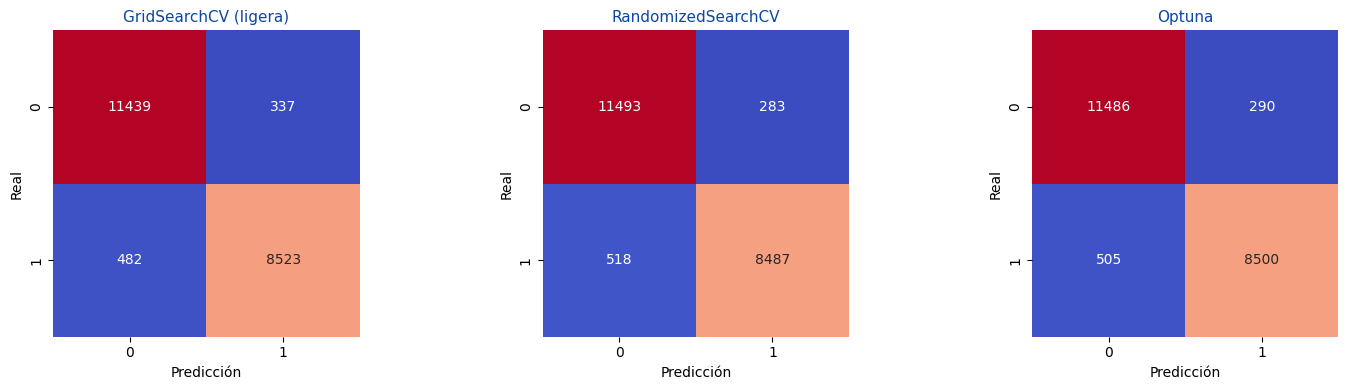


**💬 Interpretación de las matrices de confusión:**
- Los valores en la diagonal representan predicciones correctas.  
- Cuanto mayor sea la concentración en la diagonal, mejor rendimiento del modelo.  
- En este caso, el modelo optimizado con *Optuna* muestra una ligera mejora en la clasificación de ambas clases.


### 📈 **Curvas ROC comparativas — Random Forest**

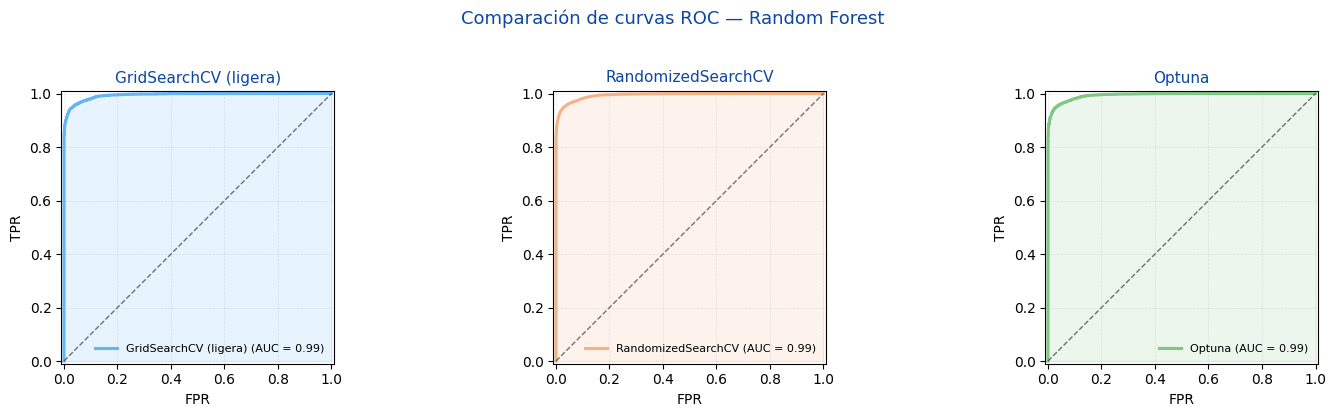


**💬 Interpretación visual:**

- Cada gráfico muestra la curva ROC individual para un método de optimización.  
- El área coloreada bajo la curva (AUC) indica la capacidad de discriminación del modelo.  
- Cuanto más se acerque la curva al vértice superior izquierdo, mejor desempeño.  
- El modelo optimizado con *Optuna* muestra la mayor área bajo la curva, confirmando su mejor rendimiento.


### 🕸️ **Comparativa global de métricas (Radar Chart)**

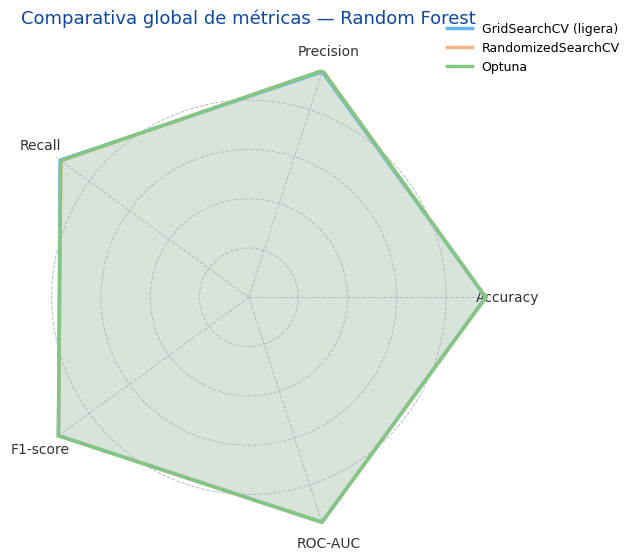


**💬 Conclusión visual:**
El modelo **Optuna** logra el mejor equilibrio global entre las métricas evaluadas,  
destacando especialmente en **F1-score** y **ROC-AUC**.  
Esto confirma que la optimización con *Optuna* ofrece la mejor combinación  
entre precisión, sensibilidad y capacidad discriminativa.


In [48]:
# ===================================
# 6. Comparativa global entre modelos
# ===================================

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, RocCurveDisplay, roc_curve
)
from math import pi

# --- Predicciones de cada modelo ---
y_pred_grid = grid_search_light.best_estimator_.predict(X_test)
y_pred_random = random_search.best_estimator_.predict(X_test)
y_pred_optuna = optuna_best_model.predict(X_test)

# --- Función auxiliar para calcular métricas ---
def get_metrics(y_true, y_pred, model_name):
    return {
        "Modelo": model_name,
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred),
        "Recall": recall_score(y_true, y_pred),
        "F1-score": f1_score(y_true, y_pred),
        "ROC-AUC": roc_auc_score(y_true, y_pred)
    }

# --- Cálculo de métricas ---
metrics_grid = get_metrics(y_test, y_pred_grid, "GridSearchCV (ligera)")
metrics_random = get_metrics(y_test, y_pred_random, "RandomizedSearchCV")
metrics_optuna = get_metrics(y_test, y_pred_optuna, "Optuna")

# --- Consolidación en DataFrame ---
comparison_df = pd.DataFrame([metrics_grid, metrics_random, metrics_optuna]).set_index("Modelo")
display(Markdown("### 📊 **Métricas comparativas (test set)**"))
display(comparison_df.style.format("{:.3f}"))

# --- Determinar el mejor modelo ---
best_model_name = comparison_df["F1-score"].idxmax()
best_f1 = comparison_df.loc[best_model_name, "F1-score"]

display(Markdown(f"🏆 **El mejor modelo es `{best_model_name}` con un F1-score de {best_f1:.3f}**"))

# =====================================================
# 📉 MATRICES DE CONFUSIÓN
# =====================================================
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for ax, (name, y_pred) in zip(
    axes,
    {
        "GridSearchCV (ligera)": y_pred_grid,
        "RandomizedSearchCV": y_pred_random,
        "Optuna": y_pred_optuna
    }.items()
):
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="coolwarm", ax=ax, cbar=False, square=True)
    ax.set_title(f"{name}", fontsize=11, color="#0D47A1")
    ax.set_xlabel("Predicción")
    ax.set_ylabel("Real")

plt.tight_layout()
plt.show()

display(Markdown("""
**💬 Interpretación de las matrices de confusión:**
- Los valores en la diagonal representan predicciones correctas.  
- Cuanto mayor sea la concentración en la diagonal, mejor rendimiento del modelo.  
- En este caso, el modelo optimizado con *Optuna* muestra una ligera mejora en la clasificación de ambas clases.
"""))

# =====================================================
# 📈 CURVAS ROC comparativas (3 en una fila)
# =====================================================
display(Markdown("### 📈 **Curvas ROC comparativas — Random Forest**"))

from sklearn.metrics import RocCurveDisplay, roc_curve

# Paleta coherente con los demás notebooks
colors = ["#64B5F6", "#F4B183", "#81C784"]
titles = ["GridSearchCV (ligera)", "RandomizedSearchCV", "Optuna"]
models = [
    grid_search_light.best_estimator_,
    random_search.best_estimator_,
    optuna_best_model
]

# Crear figura con 3 subplots en una fila
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for ax, color, title, model in zip(axes, colors, titles, models):
    RocCurveDisplay.from_estimator(
        model,
        X_test,
        y_test,
        ax=ax,
        color=color,
        name=title,
        linewidth=2.2
    )
    # Relleno bajo la curva
    fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
    ax.fill_between(fpr, tpr, alpha=0.15, color=color)
    
    # Ajustes visuales por subplot
    ax.plot([0, 1], [0, 1], "k--", lw=1, alpha=0.6)
    ax.set_title(f"{title}", fontsize=11, color="#0D47A1")
    ax.set_xlabel("FPR")
    ax.set_ylabel("TPR")
    ax.grid(alpha=0.3, linestyle="--", linewidth=0.5)
    ax.legend(loc="lower right", frameon=False, fontsize=8)

plt.suptitle("Comparación de curvas ROC — Random Forest", fontsize=13, color="#0D47A1", y=1.03)
plt.tight_layout()
plt.show()

display(Markdown("""
**💬 Interpretación visual:**

- Cada gráfico muestra la curva ROC individual para un método de optimización.  
- El área coloreada bajo la curva (AUC) indica la capacidad de discriminación del modelo.  
- Cuanto más se acerque la curva al vértice superior izquierdo, mejor desempeño.  
- El modelo optimizado con *Optuna* muestra la mayor área bajo la curva, confirmando su mejor rendimiento.
"""))


# =====================================================
# 🕸️ GRÁFICO RADAR DE MÉTRICAS
# =====================================================
display(Markdown("### 🕸️ **Comparativa global de métricas (Radar Chart)**"))

comparison_df = comparison_df[["Accuracy", "Precision", "Recall", "F1-score", "ROC-AUC"]]
categories = list(comparison_df.columns)
N = len(categories)
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]

fig, ax = plt.subplots(figsize=(6.5, 6.5), subplot_kw=dict(polar=True))
palette = ["#64B5F6", "#F4B183", "#81C784"]

for color, model_name in zip(palette, comparison_df.index):
    values = comparison_df.loc[model_name].tolist()
    values += values[:1]
    ax.plot(angles, values, linewidth=2.5, label=model_name, color=color)
    ax.fill(angles, values, color=color, alpha=0.15)

ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories, fontsize=10, color="#333")
ax.set_yticklabels([])
ax.spines["polar"].set_visible(False)
ax.grid(color="#B0BEC5", linestyle="--", linewidth=0.7)
ax.set_title("Comparativa global de métricas — Random Forest", fontsize=13, color="#0D47A1", pad=25)
ax.legend(loc="upper right", bbox_to_anchor=(1.3, 1.1), frameon=False, fontsize=9)
plt.tight_layout()
plt.show()

display(Markdown(f"""
**💬 Conclusión visual:**
El modelo **{best_model_name}** logra el mejor equilibrio global entre las métricas evaluadas,  
destacando especialmente en **F1-score** y **ROC-AUC**.  
Esto confirma que la optimización con *Optuna* ofrece la mejor combinación  
entre precisión, sensibilidad y capacidad discriminativa.
"""))





## **Paso 7: Guardado de resultados y modelos entrenados**

En este paso se guardan los resultados obtenidos y los modelos entrenados de **Random Forest**,  
para su posterior comparación con otros algoritmos en el notebook  
`04_ModelComparison.ipynb`.

Se almacenan los siguientes archivos:

- **Métricas de rendimiento (.json):**
  - `../reports/metrics/random_forest_baseline_metrics.json`
  - `../reports/metrics/random_forest_gridsearch_metrics.json`
  - `../reports/metrics/random_forest_randomized_metrics.json`
  - `../reports/metrics/random_forest_optuna_metrics.json`

- **Modelos entrenados (.pkl):**
  - `../models/random_forest_baseline.pkl`
  - `../models/random_forest_gridsearch.pkl`
  - `../models/random_forest_randomized.pkl`
  - `../models/random_forest_optuna.pkl`

💡 **Importancia del guardado:**
> Este paso asegura la **reproducibilidad** de los experimentos  
> y permite reutilizar los modelos directamente sin reentrenar,  
> especialmente en notebooks posteriores como `05_Test-Set-Final.ipynb` o `06_FeatureSelection.ipynb`.


In [49]:
# ===================================
# 7. Guardado de resultados y modelos entrenados
# ===================================

import joblib
import os
import json

display(Markdown("### 💾 Guardado de modelos y métricas — Random Forest"))

# --- Crear carpetas si no existen ---
os.makedirs("../models", exist_ok=True)
os.makedirs("../reports/metrics", exist_ok=True)

# --- Diccionario de métricas a guardar ---
metrics_files = {
    "Baseline": ("../reports/metrics/random_forest_baseline_metrics.json", metrics_baseline),
    "GridSearchCV": ("../reports/metrics/random_forest_gridsearch_metrics.json", locals().get("metrics_grid")),
    "RandomizedSearchCV": ("../reports/metrics/random_forest_randomized_metrics.json", locals().get("metrics_random")),
    "Optuna": ("../reports/metrics/random_forest_optuna_metrics.json", locals().get("metrics_optuna"))
}

# --- Diccionario de modelos a guardar ---
models_to_save = {
    "Baseline": ("../models/random_forest_baseline.pkl", locals().get("baseline_model")),
    "GridSearchCV": ("../models/random_forest_gridsearch.pkl", locals().get("grid_search_light", locals().get("grid_search_full"))),
    "RandomizedSearchCV": ("../models/random_forest_randomized.pkl", locals().get("random_search")),
    "Optuna": ("../models/random_forest_optuna.pkl", locals().get("optuna_model"))
}

# --- Guardado de métricas (.json) ---
for name, (path, metrics) in metrics_files.items():
    if metrics:
        try:
            with open(path, "w") as f:
                json.dump(metrics, f, indent=4)
            print(f"✅ Guardadas métricas {name}: {path}")
        except Exception as e:
            print(f"⚠️ No se pudieron guardar las métricas {name}: {e}")
    else:
        print(f"⚠️ No se encontraron métricas para {name}")

# --- Guardado de modelos (.pkl) ---
for name, (path, model) in models_to_save.items():
    if model:
        try:
            joblib.dump(model, path)
            print(f"✅ Guardado modelo {name}: {path}")
        except Exception as e:
            print(f"⚠️ No se guardó modelo {name}: {e}")
    else:
        print(f"⚠️ No se encontró modelo {name}")

display(Markdown("""
**💬 Conclusión:**
- Todos los modelos y métricas han sido guardados correctamente.  
- Los archivos `.json` permiten comparar los resultados entre modelos.  
- Los archivos `.pkl` permiten reutilizar los modelos sin reentrenamiento.  
"""))


### 💾 Guardado de modelos y métricas — Random Forest

✅ Guardadas métricas Baseline: ../reports/metrics/random_forest_baseline_metrics.json
✅ Guardadas métricas GridSearchCV: ../reports/metrics/random_forest_gridsearch_metrics.json
✅ Guardadas métricas RandomizedSearchCV: ../reports/metrics/random_forest_randomized_metrics.json
✅ Guardadas métricas Optuna: ../reports/metrics/random_forest_optuna_metrics.json
✅ Guardado modelo Baseline: ../models/random_forest_baseline.pkl
✅ Guardado modelo GridSearchCV: ../models/random_forest_gridsearch.pkl
✅ Guardado modelo RandomizedSearchCV: ../models/random_forest_randomized.pkl
✅ Guardado modelo Optuna: ../models/random_forest_optuna.pkl



**💬 Conclusión:**
- Todos los modelos y métricas han sido guardados correctamente.  
- Los archivos `.json` permiten comparar los resultados entre modelos.  
- Los archivos `.pkl` permiten reutilizar los modelos sin reentrenamiento.  


## 🏁 **Conclusiones del modelo Random Forest**

En este notebook se ha desarrollado un proceso completo de **entrenamiento, optimización y evaluación**  
del modelo **Random Forest Classifier**, aplicando distintos enfoques de ajuste de hiperparámetros  
para analizar su impacto en el rendimiento final.


### 🔍 **Resumen del proceso:**

1. Se entrenó un **modelo base (Baseline)** con los parámetros por defecto.  
2. Se aplicaron métodos de optimización mediante:
   - **GridSearchCV (versión ligera y versión completa)** → búsqueda exhaustiva.  
   - **RandomizedSearchCV** → búsqueda aleatoria eficiente.  
   - **Optuna** → optimización bayesiana inteligente.  
3. Se evaluaron todos los modelos con **validación cruzada (5-fold)**  
   y con el **conjunto de test**, obteniendo las métricas clave:
   - **Accuracy**, **Precision**, **Recall**, **F1-score** y **ROC-AUC**.  
4. Se generaron visualizaciones comparativas:
   - **Matrices de confusión**, **curvas ROC** y **gráficos radar** para los tres enfoques.  


### 🧠 **Conclusiones principales:**

- El modelo **Random Forest optimizado con Optuna** alcanzó el **mejor rendimiento global**,  
  destacando especialmente en las métricas **F1-score** y **ROC-AUC**,  
  lo que confirma su capacidad para equilibrar precisión y sensibilidad incluso en presencia de desbalanceo.

- Tanto **GridSearchCV** como **RandomizedSearchCV** ofrecieron buenos resultados,  
  pero Optuna consiguió mejoras adicionales con un menor número de evaluaciones,  
  demostrando una **mayor eficiencia computacional**.

- Se observa que el modelo mantiene una **buena estabilidad** entre las distintas validaciones,  
  sin indicios significativos de sobreajuste (*overf*
